In [61]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray
from optic.dsp.core import pnorm, upsample, firFilter, pulseShape, signal_power, phaseNoise, decimate
from optic.dsp.equalization import edc
from optic.models.devices import iqm, coherentReceiver
from optic.models.channels import linearFiberChannel
from optic.utils import parameters, dBm2W
from optic.plot import pconst

# Front-End do Receptor Coerente

Neste notebook iremos explorar um receptor óptico digital coerente típico. O front-end óptico é responsável por produzir uma saída que corresponde as componentes em fase e quadratura de duas orientações de polarização ortogonais que são representadas por correntes elétricas.

Essas correntes são convertidas em tensão e digitalizados por um conjunto de ADCs, gerando os sinais digitais que são enviados para um segundo subsistema, composto por uma cadeia de algoritmos de processamento digital de sinais (DSP) que tem por objetivo realizar as devidas compensações impostas pelo canal. 

Iremos apresentar o front-end do receptor e discutir os algoritmos usados para corrigir suas imperfeições usando métodos de enquadramento e ortogonalização.

### 4.1 The Receiver Front-end

Nos receptores ópticos, a conversão do sinal óptico em correntes elétricas é realizada pelo fotodetector. Fotodetectores são dispositivos optoeletrônicos que geram uma corrente elétrica $I_p(t)$ que é proporcional ao módulo quadrático do campo óptico de entrada $E_{in}(t)$

$$I_{p}(t)=R|E_{i n}(t)|^{2}$$

onde $R$ é uma constante de proporcionalidade chamada responsividade do fotodetector, medida em unidades de $A/W$. Em sistemas ópticos com modulação de intensidade e detecção direta, a conversão optoelétrica é realizada por um único fotodetector. Porém, um fotodetector não é capaz de recuperar a fase do campo de entrada.  Alternativamente, os receptores coerentes recorrem a estruturas mais elaboradas para recuperar a informação transmitida na amplitude, fase e polarização do sinal óptico.

Por definição receptores coerentes são estruturas que misturam um sinal de entrada na frequência $\omega_c$, com um oscilador local na frequência $\omega_{LO}$, para recuperar a fase da portadora de entrada. A mistura é uma operação não linear que converte o sinal na frequência $\omega_c$ para uma frequência intermediaria que denotamos por $\Delta\omega=\omega_{c}-\omega_{LO}$. A detecção coerente pode ser classificada em homódina, heteródina e intradina.

#### Tipos de detecção coerente

- **Detecção Homódina** ($\omega_{c}\;=\;\omega_{LO}$): a frequência do laser do transmissor e a frequência do laser oscilador local são idênticas.

- **Detecção Heteródina** ($\omega_{c}\neq\omega_{LO}$): a frequência do laser do transmissor e a frequência do laser oscilador local são diferentes.

- **Detecção intradina** ($\omega_{c}\approx\omega_{LO}$): a frequência do laser do transmissor e do laser oscilador local são "ligeiramente" diferentes.

Nos casos em que temos uma detecção intradina a conversão para banda base é realizada por algoritmos de recuperação de frequência implementados pelo DSP.

O front-end óptico de um receptor coerente é a estrutura que mistura o sinal óptico de entrada com o laser oscilador local, gerando correntes elétricas que representam as componentes de fase e quadratura do sinal recebido, esse dispositivo é denominado como *Hybrid*. Abaixo podemos observar um circuito fotônico que implementa uma híbrida.

<br>
<center>
    <img src="https://i.postimg.cc/2S8xRQHT/Screenshot-from-2024-03-30-19-44-56.png">
</center>
<br>

O sinal óptico $E_r(t)$ é primeiro combinado com o sinal do oscilador local $E_{LO}(t)$ em um híbrido de $90°$ que consiste em quatro acopladores de 3 dB e um deslocador de fase $\pi/2$. Para entendermos a híbrida vamos começar com o modelo de função de transferência de campo de um acoplador de 3 dB dada por

$$\tilde{H}_{c}=\frac{1}{\sqrt{2}}\left[\begin{array}{c c}{{1}}&{{1}}\\ {{1}}&{{-1}}\end{array}\right]$$

Utilizando a função de transferência é possível obter as expressões do campo elétrico dos sinais ópticos nos pontos 1, 2, 3 e 4 indicados na Fig 01.

$$E_{1}(t)={\frac{1}{2}}E_{r}(t)+{\frac{1}{2}}E_{L O}(t),$$ 
$$E_{2}(t)=\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\pi},$$
$$E_{3}(t)=\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{\pi}{2}},$$
$$E_{4}(t)=\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{3\pi}{2}}.$$

A Hibrida combina $E_r(t)$ com $E_{LO}(t)$, produzindo quatro saídas com mudança de fase mutuamente em 0, $\pi/2$, $\pi$ e $3\pi/2$ rad. Os quatro sinais ópticos são recebidos independentemente por quatro fotodetectores (também conhecidos como dois fotodetectores balanceados), que são combinados para produzir duas correntes elétricas correspondentes a componentes em fase e em quadratura.

$$i_{I}(t)=i_{1}(t)-i_{2}(t)=R\,|E_{1}(t)|^{2}-R\,|E_{2}(t)|^{2}\,,$$
$$i_{Q}(t)=i_{3}(t)-i_{4}(t)=R\,|E_{3}(t)|^{2}-R\,|E_{4}(t)|^{2}\,.$$

Subistituindo $E_r(t)$ temos a saída do fotodetector balanceado

$$i_{I}(t)=R\left|{\frac{1}{2}}E_{r}(t)+{\frac{1}{2}}E_{L O}(t)\right|^{2}-R\left|{\frac{1}{2}}E_{r}(t)+{\frac{1}{2}}E_{L O}(t)e^{j\pi}\right|^{2},$$
$$i_{Q}(t)=R\left|\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{\pi}{2}}\right|^{2}-R\left|\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{\omega}{2}}\right|^{2}.$$

Ainda podemos simplificar utilizando a seguinte propriedade

$$|z+k|^{2}=|z|^{2}+|k|^{2}+2\mathbb{R}\{zk^{*}\}$$
$$i_{I}(t)=R\mathbb{R}\left\{E_{r}(t)E_{L O}^{*}(t)\right\}$$
$$i_Q(t) = R\mathbb{R}\left\{E_{r}(t)\left[E_{LO}(t)e^{j\pi/2}\right]^{*}\right\}$$

Se considerarmos a condição em que temos uma detecção coerente intradina é coveniente usar o chamado pré-envelope ou representação analítica de $x(t)$, $x_a(t) = x_b(t)e^{i\omega_ct}$ gerando após a detecção um sinal em frequência intermediária $\Delta\omega$. Assim, assumindo que $E_r(t)$ possui uma modulação de amplitude $A_r(t)$ e uma modulação de fase $\phi_r(t)$, é possível escrever o pré-envelope do sinal recebido como:

$$E_r(t) = A_{r}\left(t\right)e^{j\left[\phi_{r}\left(t\right)+\omega_{c}t\right]}$$

Além disso, assumindo um oscilador local ideal,

$$E_{LO}(t) = A_{LO}\left(t\right)e^{j\left[j\omega_{LO}t\right]}$$

Assim podemos reescrever as correntes $i_{I}(t)$ e $i_{Q}(t)$ como,

$$i_{I}(t)=A_{r}(t)A_{LO}R\mathbb{R}\left\{e^{j[\phi_{r}(t)+\Delta\omega t]}\right\}=A_{r}(t)A_{LO}R\mathrm{cos}(\phi_{r}(t)+\Delta\omega t)$$
$$i_{Q}(t)=A_{r}(t)A_{LO}R\mathbb{R}\left\{e^{j[\phi_{r}(t)+\Delta\omega t-\pi/2]}\right\}=A_{r}(t)A_{L O}R\sin(\phi_{r}(t)+\Delta\omega t)$$

#### Sinal complexo detectado

$$s(t) = i_I(t) + ji_Q(t)$$
$$s(t) = A_{r}(t)A_{LO}R(\mathrm{cos}(\phi_{r}(t)+\Delta\omega t) + j\sin(\phi_{r}(t)+\Delta\omega t))$$
$$s(t) = A_{r}(t)A_{LO}Re^{j(\phi_{r}(t)+\Delta\omega t)}$$

Sabendo que $\Delta\omega=\omega_{c}-\omega_{LO}$

$$s(t) = A_{r}(t)A_{LO}Re^{j(\phi_{r}(t)+(\omega_{c}-\omega_{LO})t)}$$

### 4.2 Deskew

O bloco Deskew compensa um desalinhamento temporal entre os componentes em fase e em quadratura na saída dos ADCs. A compensação de inclinação deve ser realizada antes que os componentes em fase e quadratura sejam combinados e processados por algoritmos de processamento de sinal linear. Os valores de distorção (atraso) geralmente são medidos na fábrica e, em geral, não requerem estimativa.

A principal dificuldade na implementação do bloco de enquadramento é que o desvio temporal geralmente corresponde a uma fração do tempo entre as amostras.

Qualquer atraso temporal $\tau$ pode ser expresso como:

$$\tau\,=n\,T_{\mathrm{ADC}}+\mu T_{\mathrm{ADC}}$$

onde $T_{ADC}$ é o período de amostragem, $n$ é um número inteiro de amostras e $\mu$ é um atraso fracionário $(0~\lt ~\mu~\lt ~1)$. Embora o atraso de um número inteiro de amostras $n$ é simples de implementar usando registradores de deslocamento, o atraso fracionário $\mu$ requer um interpolador. O princípio da interpolação é aproximar um conjunto de sinais recebidos $r[n]$ por uma função de valor contínuo $r(t)$ e reamostra $r(t)$ nos pontos de amostragem corretos.

Várias soluções foram propostas para realizar compensação de distorção em sistemas ópticos, por exemplo, no domínio da frequência, ou a partir da equalização adaptativa. No entanto, a solução mais comum é talvez aquela baseada em filtros de resposta de impulso finito (FIR) que implementam a interpolação de Lagrange.

Dado um conjunto de $N + 1$ amostras recebidas $r[0] . . . r[N]$ nos instantes $t[0] . . . t[N]$, o polinômio de interpolação em um instante arbitrário $t\left(t[0]\leq t\leq t[N]\right)$ é dado por:

$$r(t)=\sum_{n=0}^{N}L_{n}(t)r[n],$$

Onde as funções de ponderação, $L_n(t)$, são calculadas como:

$$L_{n}(t)=\prod_{m=0,m\neq n}{\frac{t-t[m]}{t[n]-t[m]}}$$

### Transmissor
**geração de sinal de polarização única**

In [2]:
# Transmitter parameters
M = 16                  # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rcc'       # Pulso a ser utilizado
Rs = 10e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 70           # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]
paramFiber.Fc = 193.1e12    # Hz

### Core simulation

Potência média do sinal óptico modulado [mW]: 1.190 mW
Potência média do sinal óptico modulado [dBm]: 0.757 dBm


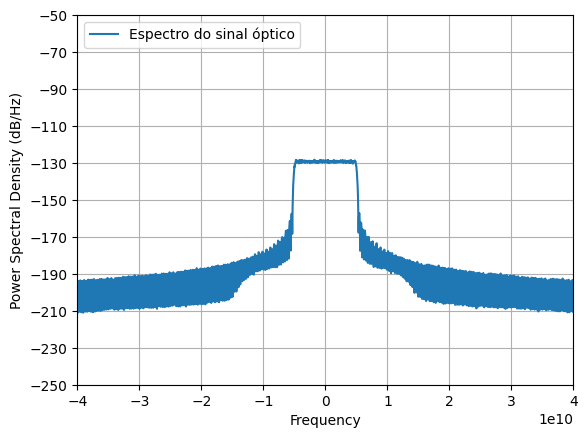

In [3]:
plotPSD = True

# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(8e4*np.log2(M)))

symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # symbol power normalization

symbolsUp = upsample(symbTx, SpS)

if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rcc":
    pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Simula um front-end do receptor coerente sujeito a ruído de fase do laser

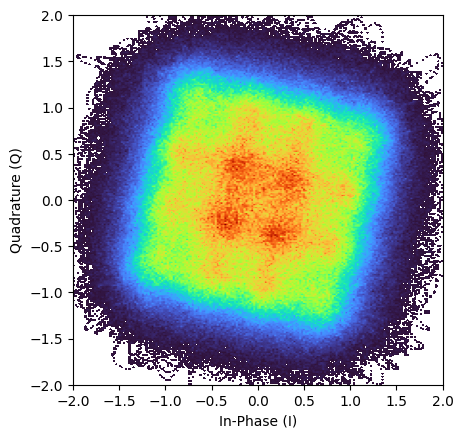

In [4]:
# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# parâmetros do receptor
B = 10e9            # banda do receptor em Hz
Plo_dBm  = 10       # potência do oscilador local
Δf_lo    = 0        # desvio de frequência do oscilador local
ϕ_lo     = 0        # fase do oscilador local
lw       = 100      # laser linewidth Hz

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# sinal na saída do front-end do receptor coerente
sigRx_ = coherentReceiver(sigRxo, sigLO)
pconst(sigRx_, R = 2);

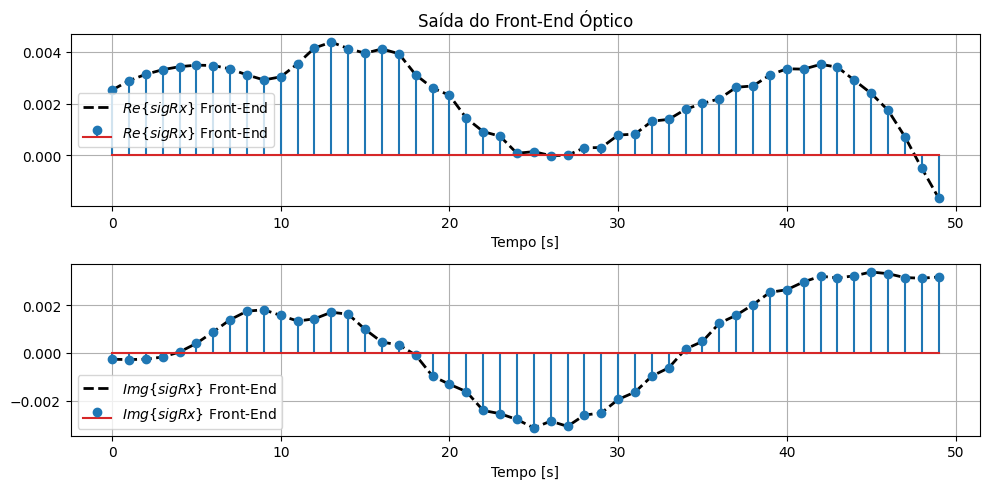

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].plot(sigRx_[0:200:4].real, '--', color='black', linewidth=2, label='$Re\{{sigRx}\}$ Front-End')
axs[0].stem(sigRx_[0:200:4].real, label='$Re\{{sigRx}\}$ Front-End')
axs[0].grid(True)
axs[0].set_title('Saída do Front-End Óptico')
axs[0].set_xlabel('Tempo [s]')
axs[0].legend();
axs[1].plot(sigRx_[0:200:4].imag, '--', color='black', linewidth=2, label='$Img\{{sigRx}\}$ Front-End')
axs[1].stem(sigRx_[0:200:4].imag, label='$Img\{{sigRx}\}$ Front-End')
axs[1].set_xlabel('Tempo [s]')
axs[1].grid(True)
axs[1].legend();

plt.tight_layout()

In [67]:
def InsertSkew(In, ParamSkew):

    TimeI = np.arange(0, len(In.real))
    TimeQ = np.arange(0, len(In.imag))

    interpI = interp1d(TimeI, In.real)
    interpQ = interp1d(TimeI, In.imag)
    
    timeSkewI = np.clip(TimeI+ParamSkew.TauIV, TimeI[0], TimeI[-1])
    timeSkewQ = np.clip(TimeI+ParamSkew.TauQV, TimeI[0], TimeI[-1])

    I = interpI(timeSkewI)
    Q = interpQ(timeSkewQ)

    sigRx = I + 1j*Q

    return sigRx

### Adiciona atraso ao sinal na saída do front-end óptico

In [68]:
ParamSkew = parameters()
# Atrasa as componentes de fase e quadratura dado em segundos [s]
ParamSkew.TauIV = 5
ParamSkew.TauQV = 1
sigRx = InsertSkew(sigRx_, ParamSkew)

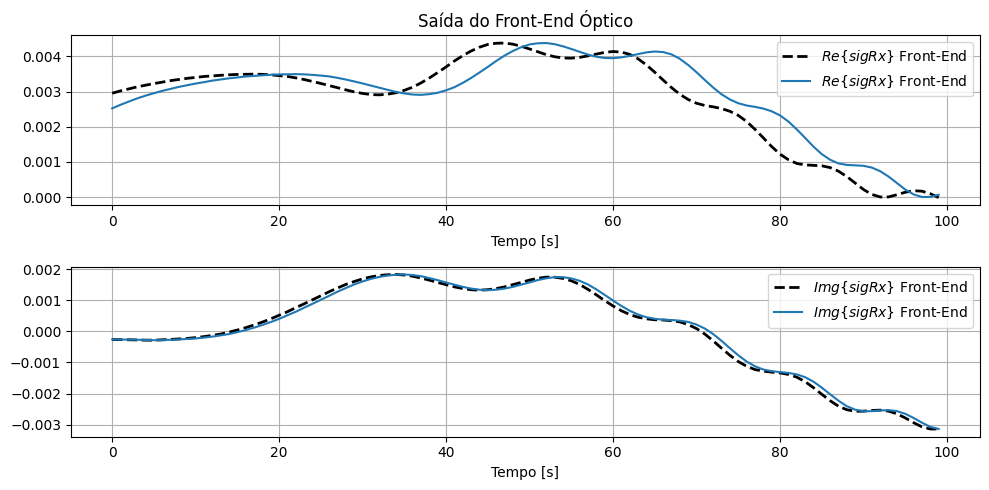

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].plot(sigRx[0:100].real, '--', color='black', linewidth=2, label='$Re\{{sigRx}\}$ Front-End')
axs[0].plot(sigRx_[0:100].real, label='$Re\{{sigRx}\}$ Front-End')
axs[0].grid(True)
axs[0].set_title('Saída do Front-End Óptico')
axs[0].set_xlabel('Tempo [s]')
axs[0].legend();
axs[1].plot(sigRx[0:100].imag, '--', color='black', linewidth=2, label='$Img\{{sigRx}\}$ Front-End')
axs[1].plot(sigRx_[0:100].imag, label='$Img\{{sigRx}\}$ Front-End')
axs[1].set_xlabel('Tempo [s]')
axs[1].grid(True)
axs[1].legend();

plt.tight_layout()

### 4.3 Orthogonalization

Idealmente, os componentes em fase e em quadratura recebidos do front-end do receptor são ortogonais, no sentido de que não são correlacionados. No entanto, imperfeições no transmissor ou receptor podem causar desequilíbrios que induzem uma perda de ortogonalidade.

Alguns exemplos de imperfeições que contribuem para esses desequilíbrios são a polarização incorreta de moduladores em fase e de quadratura e imperfeições em divisores de potência, acopladores ópticos e híbridos.

A não ortogonalidade entre os componentes em fase e quadratura se traduz em distorções na constelação do sinal recebido, afetando o desempenho do sistema. Quanto maior a ordem do formato de modulação, mais severas serão as penalidades de desempenho.

### Transmissor
**geração de sinal de polarização única**

In [83]:
# Transmitter parameters
M = 16                  # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rcc'       # Pulso a ser utilizado
Rs = 10e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 70           # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]
paramFiber.Fc = 193.1e12    # Hz

### Core simulation

Potência média do sinal óptico modulado [mW]: 1.190 mW
Potência média do sinal óptico modulado [dBm]: 0.756 dBm


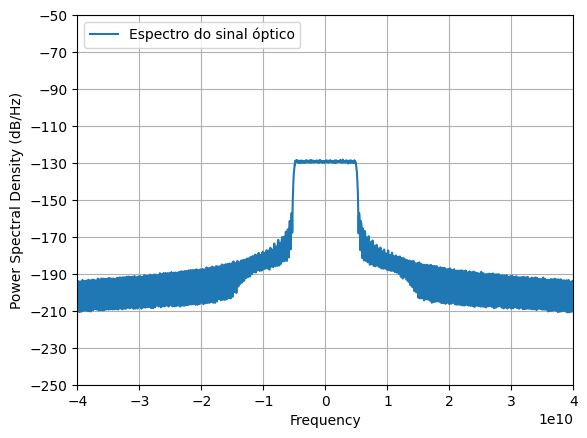

In [84]:
plotPSD = True

# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(8e4*np.log2(M)))

symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # symbol power normalization

symbolsUp = upsample(symbTx, SpS)

if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rcc":
    pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Simula um front-end do receptor coerente sujeito a ruído de fase do laser

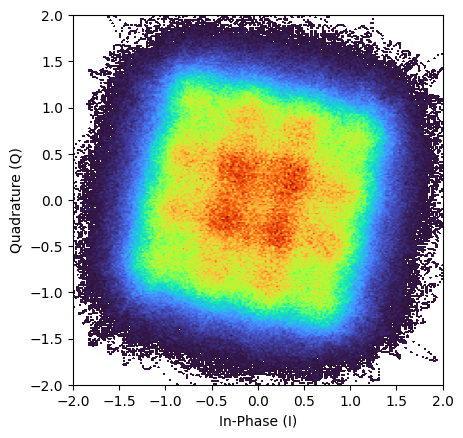

In [85]:
# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# parâmetros do receptor
B = 10e9            # banda do receptor em Hz
Plo_dBm  = 10       # potência do oscilador local
Δf_lo    = 0        # desvio de frequência do oscilador local
ϕ_lo     = 0        # fase do oscilador local
lw       = 100      # laser linewidth Hz

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# sinal na saída do front-end do receptor coerente
sigRx_ = coherentReceiver(sigRxo, sigLO)
pconst(sigRx_, R = 2);

### Filtragem correspondente

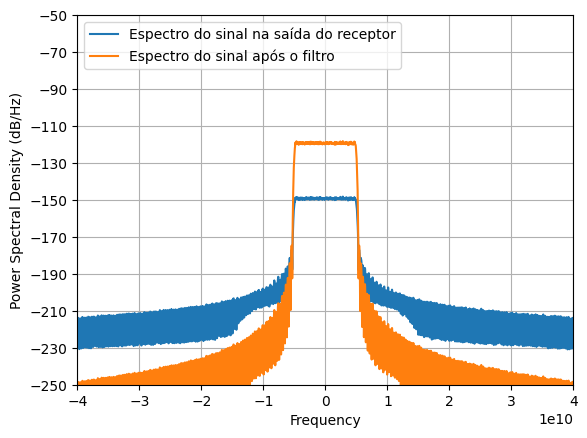

In [86]:
sigRx = firFilter(pulse, sigRx_)

plt.figure();
plt.ylim(-250,-50);
plt.psd(sigRx_, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal na saída do receptor')
plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal após o filtro')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);

### Compensa a dispersão cromática, reduz a resolução para 1 amostra/símbolo e normaliza a potência

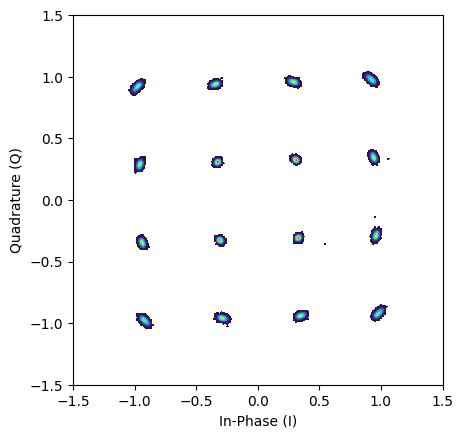

In [87]:
# compensa dispersão cromática
sigRx = edc(sigRx, paramFiber)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza constelação recebida
sigRx = pnorm(sigRx)
pconst(sigRx, R=1.5);

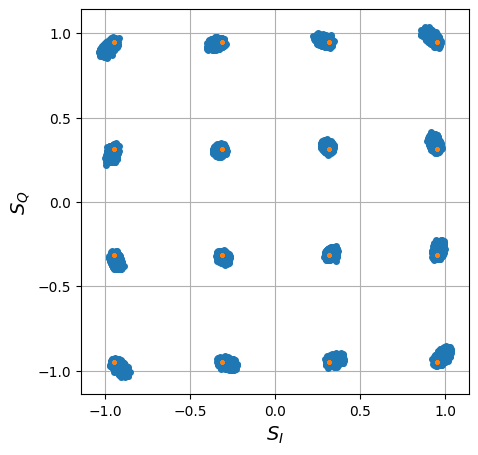

In [88]:
plt.figure(figsize=(5, 5))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.grid()

plt.plot(sigRx[ind].real, sigRx[ind].imag,'o', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'.', markersize=4, label='Tx');

### Gram–Schmidt orthogonalization GSOP algorithm

A etapa de ortogonalização visa recuperar a característica ortogonal entre os componentes em fase e quadratura dos sinais. Existem diversas técnicas que realizam esta tarefa, sendo o procedimento de ortogonalização de Gram-Schmidt (GSOP) o mais comum em receptores ópticos.

Além da ortogonalização, o GSOP também normaliza os componentes em fase e quadratura para potência unitária. O conjunto de operações envolvidas no GSOP é fornecido por [2] Fatadin et al.

$$r_{I}^{o r t}[n]=\frac{r_{I}[n]}{\sqrt{\operatorname{E}\left\{r_{I}^{2}[n]\right\}}},$$
$$r_{Q}^{i n t}[n]=r_{Q}[n]-\frac{{\operatorname E}\left\{r_{I}[n]r_{Q}[n]\right\}r_{I}[n]}{{\operatorname E}\left\{r_{I}^{2}[n]\right\}},$$
$$r_{Q}^{o r t}[n]=\frac{r_{Q}^{i n}[n]}{\sqrt{\operatorname*{E}\left\{\left(r_{Q}^{i n t}[n]\right)^{2}\right\}}},$$

Onde $r_I[n]$ e $r_Q[n]$ são as sequências de tempo discreto em fase e quadratura obtidas após o bloco de enquadramento, e $E\{{.}\}$ é o operador de valor esperado.

In [89]:
def gsop(rLn):
    """ Esta função realiza a ortogonalização de Gram-Schmidt no sinal 'rLn'

    Args:
        rLn (np.array): Sinal de entrada no qual será realizada a ortogonalização.
    Returns:
        sigRx (np.array): Sinal após ortogonalização de Gram-Schmidt.
    """
    # A 1ª e 2ª colunas devem conter as componentes em fase e quadratura do sinal, respectivamente.
    Rin = np.array([rLn.real, rLn.imag]).T
    
    # Tomando como referência a componente em quadratura:
    rQOrt = Rin[:,1]/np.sqrt(np.mean(Rin[:,1]**2))
    # Orthogonalization:    
    rIInt = Rin[:,0]-np.mean(Rin[:,1]*Rin[:,0])*Rin[:,1]/np.mean(Rin[:,1]**2)
    rIOrt = rIInt/np.sqrt(np.mean(rIInt**2))

    sigRx = rIOrt + 1j*rQOrt

    return sigRx

### Simula possível imperfeição no front-end do receptor

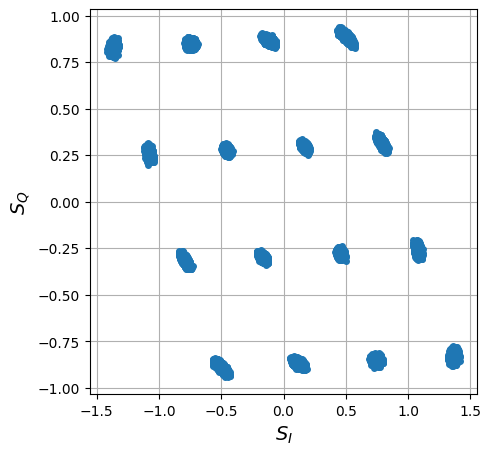

In [90]:
phi   = 25*np.pi/180
alpha = 0.5
sigRx = sigRx.real-sigRx.imag*np.sin(phi) + 1j*sigRx.imag*np.cos(phi)

plt.figure(figsize=(5, 5))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.grid()

plt.plot(sigRx[ind].real, sigRx[ind].imag,'o', markersize=4, label='Rx')

Abaixo e possível visualizar a ortogonalização de Gram-Schmidt aplicada a constelação realizando a correção sobre as imperfeições do front-end óptico.

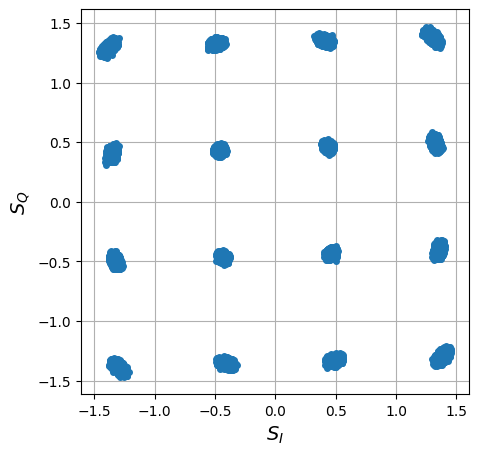

In [91]:
sigRx = gsop(sigRx)

plt.figure(figsize=(5, 5))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.grid()

plt.plot(sigRx[ind].real, sigRx[ind].imag,'o', markersize=4, label='Rx')

# Referências

[1] Digital Coherent Optical Systems, Architecture and Algorithms

[[2]](https://ieeexplore.ieee.org/document/4633708) I. Fatadin, S.J. Savory, D. Ives, Compensation of quadrature imbalance in an optical QPSK coherent receiver. IEEE Photon. Technol. Lett. 20(20), 1733–1735 (2008)